In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
# from matplotlib import colors as mcolors
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [ ]:
# calculate the phase map as function of theta and phi. 
# show theta, phi, and eta, here eta is the angle between the major norm and the y axis. 

# calculate Table result
importlib.reload(jm)

for ini_psi in np.linspace(0, 2 * np.pi, 15, endpoint=0)[:1]:
    max_t = 1000
    n_theta = 24
    n_phi = 48
#     n_theta = 4
#     n_phi = 4
    t0 = time()
    idx_list = []
    Table_t_list = []
    Table_theta_list = []
    Table_phi_list = []
    Table_psi_list = []
    Table_eta_list = []
    ini_theta_list = []
    ini_phi_list = []
    idx = 0
    planeShearRate = np.array((1, 0, 0))
    for ini_theta in tqdm_notebook(np.linspace(0, np.pi, n_theta), desc='$\\psi_{ini}$=%5.3f' % ini_psi):
        for ini_phi in np.linspace(0, 2 * np.pi, n_phi):
            tnorm = np.array((np.sin(ini_theta) * np.cos(ini_phi), 
                              np.sin(ini_theta) * np.sin(ini_phi), 
                              np.cos(ini_theta)))
            Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
                = spf_tb.do_calculate_ecoli_passive_Petsc(tnorm, ini_psi, max_t, update_fun='3bs', 
                                        rtol=1e-6, atol=1e-9)
            idx_list.append(idx)
            Table_t_list.append(Table_t)
            Table_theta_list.append(Table_theta)
            Table_phi_list.append(Table_phi)
            Table_psi_list.append(Table_psi)
            Table_eta_list.append(Table_eta)
            ini_theta_list.append(ini_theta)
            ini_phi_list.append(ini_phi)
            idx = idx + 1
    data = pd.DataFrame({'ini_theta':  np.hstack(ini_theta_list), 
                         'ini_phi':    np.hstack(ini_phi_list), 
                         'idx':    np.hstack(idx_list), 
                         'last_theta': np.hstack([Table_theta[-1] for Table_theta in Table_theta_list]), 
                         'last_phi':   np.hstack([Table_phi[-1] for Table_phi in Table_phi_list]), 
                         'last_psi':   np.hstack([Table_psi[-1] for Table_psi in Table_psi_list]), 
                         'last_eta':   np.hstack([Table_eta[-1] for Table_eta in Table_eta_list]), 
                        }).pivot_table(index=['ini_theta', 'ini_phi'])
    idx = data.idx.unstack()
    last_theta = data.last_theta.unstack()
    last_phi = data.last_phi.unstack()
    last_psi = data.last_psi.unstack()
    last_eta = data.last_eta.unstack()
    t1 = time()
    print('calculate phase map: run %d cases using %fs' % ((n_theta * n_phi), (t1 - t0)))

    tpick = (idx, ini_psi, last_theta, last_phi, last_eta, last_psi, 
             Table_t_list, Table_theta_list, Table_phi_list, Table_psi_list, Table_eta_list)
    tname = 'phase_map_passive_ecoli_%5.3f.pickle' % ini_psi
    with open(tname, 'wb') as handle:
        pickle.dump(tpick, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('save table_data to %s' % tname)


In [ ]:
last_eta.shape

In [ ]:
def tplot_fun(ax0, file_handle, t1, vmin=0, vmax=np.pi):
    tx = t1.columns.values
    ty = t1.index.values
    plt.sca(ax0)
    im = ax0.pcolor(tx / np.pi, ty / np.pi, t1.values / np.pi, 
                    cmap=cm.RdBu, vmin=vmin / np.pi, vmax=vmax / np.pi)
    fig.colorbar(im, ax=ax0).ax.tick_params(labelsize=fontsize*0.8)
    ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
    ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
    ax0.set_title('%s' % file_handle, size=fontsize*0.8)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    return True

with open('phase_map_ecoli_0.000.pickle', 'rb') as handle:
    tpick = pickle.load(handle)
idx, ini_psi, last_theta, last_phi, last_eta, last_psi, \
  Table_t_list, Table_theta_list, Table_phi_list, Table_psi_list, Table_eta_list = tpick

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(100, 20))
fig.patch.set_facecolor('white')

tplot_fun(ax0, 'last_eta', last_eta, vmin=0, vmax=np.pi)
tplot_fun(ax1, 'last_theta', last_theta, vmin=0, vmax=np.pi)
tplot_fun(ax2, 'last_phi', last_phi, vmin=0, vmax=2 * np.pi)
tplot_fun(ax3, 'last_psi', last_psi, vmin=0, vmax=2 * np.pi)
pass


In [ ]:
display(idx[:0.3*np.pi].T[np.pi:1.7*np.pi].T)
display(last_eta[:0.3*np.pi].T[np.pi:1.7*np.pi].T / np.pi)
display(last_psi[:0.3*np.pi].T[np.pi:1.7*np.pi].T / np.pi)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
display(last_eta / np.pi)

In [ ]:
show_idx = 74

tt = Table_t_list[show_idx]
ttheta = Table_theta_list[show_idx]
tphi = Table_phi_list[show_idx]
tpsi = Table_psi_list[show_idx]
teta = Table_eta_list[show_idx]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(tt, ttheta, '-*')
ax1.plot(tt, tphi, '-*')
ax2.plot(tt, tpsi, '-*')
ax3.plot(tt, teta, '-*')
print(ttheta[0], ',', tphi[0], ',', tpsi[0])

In [ ]:
t_theta, t_phi, t_psi = 0, 0, 0
t_name = 'theta%5.3f_phi%5.3f_psi%5.3f.pickle' % (t_theta, t_phi, t_psi)
with open('../motion_ecoliB01_table/%s' % t_name, 'rb') as handle:    
    tpick = pickle.load(handle)
max_t, t_theta, t_phi, t_psi, tnorm, Table_t, Table_X, Table_P, Table_P2, \
         Table_theta, Table_phi, Table_psi, Table_eta = tpick
print('load table_data from %s' % t_name)

t0 = 0
t1 = t0 + 100
idx = (t0 < Table_t) & (Table_t <  t1)
show_table_result(Table_t[idx], Table_theta[idx], Table_phi[idx], Table_psi[idx], 
                  Table_eta[idx], Table_X[idx])


In [ ]:
t0 = 0
t1 = t0 + 1000
idx = (t0 < Table_t) & (Table_t <  t1)

fig = plt.figure(figsize=(10, 10))
ax0 = fig.add_subplot(111, polar=True)
fig.patch.set_facecolor('white')

norm=plt.Normalize(Table_t.min(), Table_t.max())
cmap=plt.get_cmap('jet')
ax0.plot(Table_phi / np.pi, Table_theta / np.pi, ' ')
lc = ax0.scatter(Table_phi[idx], Table_theta[idx], c=Table_t[idx], cmap=plt.get_cmap('jet'), s=fontsize*0.1)
clb = fig.colorbar(lc, ax=ax0, orientation="vertical")
clb.ax.tick_params(labelsize=fontsize*0.5)
clb.ax.set_title('time', size=fontsize*0.5)
# ax0.set_xlabel('$\\phi / \pi$', size=fontsize*0.7)
# ax0.set_ylabel('$\\theta / \pi$', size=fontsize*0.7)
ax0.set_ylim(0,np.pi)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)


last norm:  1.52487567479 , 1.84560195052 , 5.13033087849
do_calculate_ellipse_RK: run 100 loops/times using 5.459821s


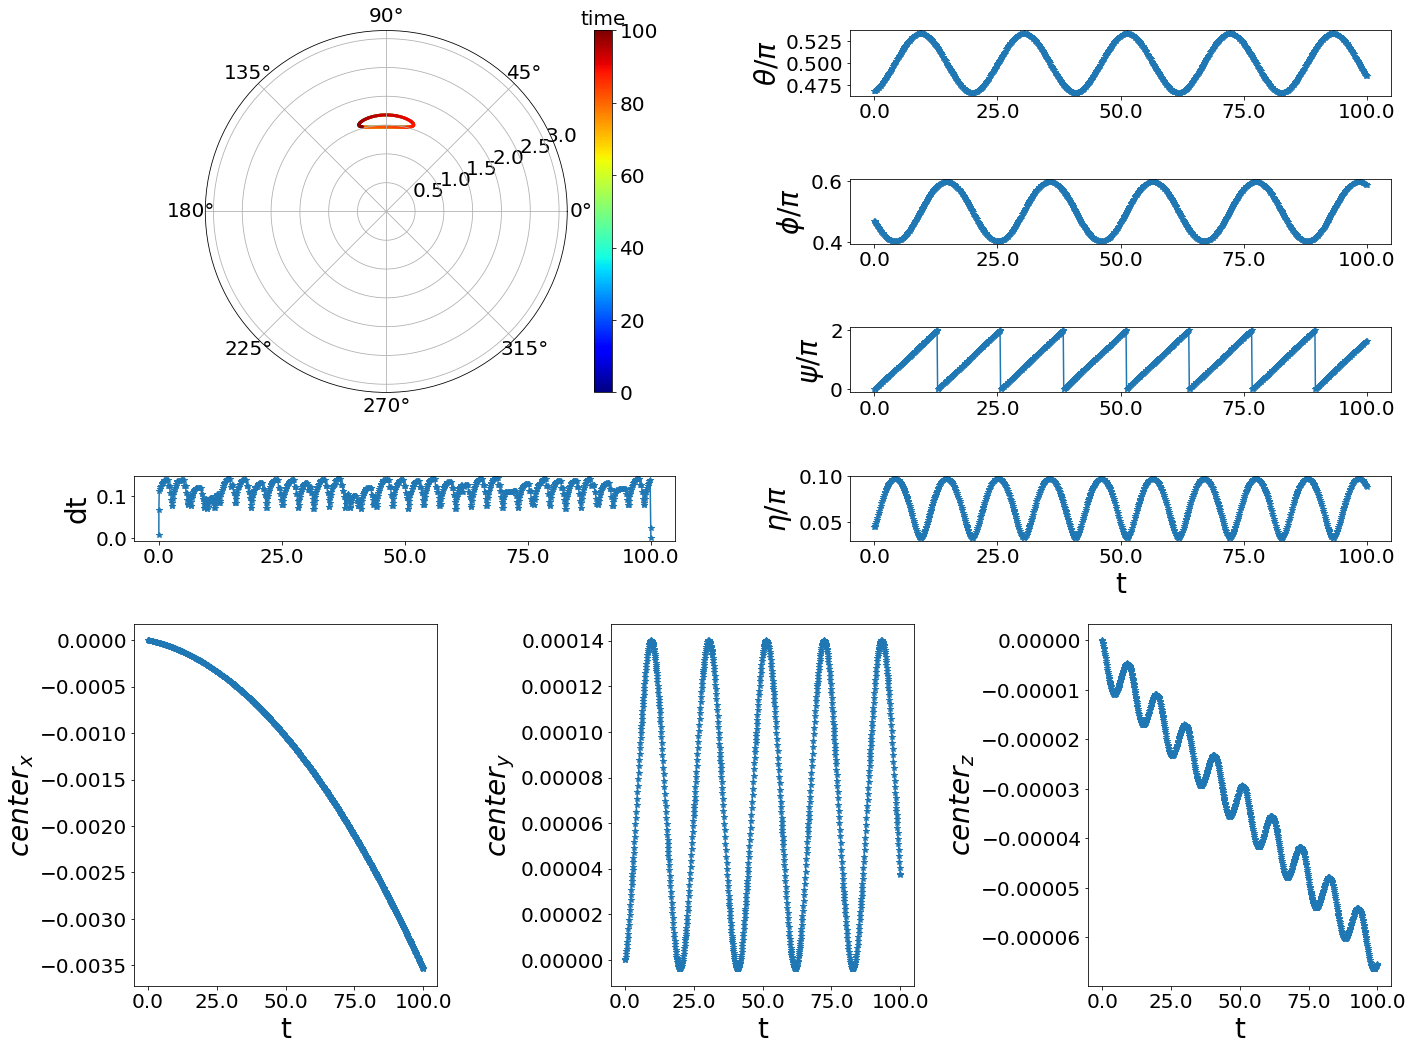

In [17]:
# passive ellipse RK method. 
importlib.reload(spf_tb)
t0 = time()
norm = np.array((0.1, 1, 0.1))
# norm = np.array((0, 0, 1))
ini_psi = 0
max_t = 100
Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
           = spf_tb.do_calculate_ellipse_RK(norm, ini_psi, max_t, rtol=1e-9, atol=1e-12)
spf_tb.show_table_result(Table_t, Table_theta, Table_phi, Table_psi, Table_eta, Table_X)
t1 = time()
print('last norm: ', Table_theta[-1], ',', Table_phi[-1], ',', Table_psi[-1])
print('%s: run %d loops/times using %fs' % ('do_calculate_ellipse_RK', max_t, (t1 - t0)))


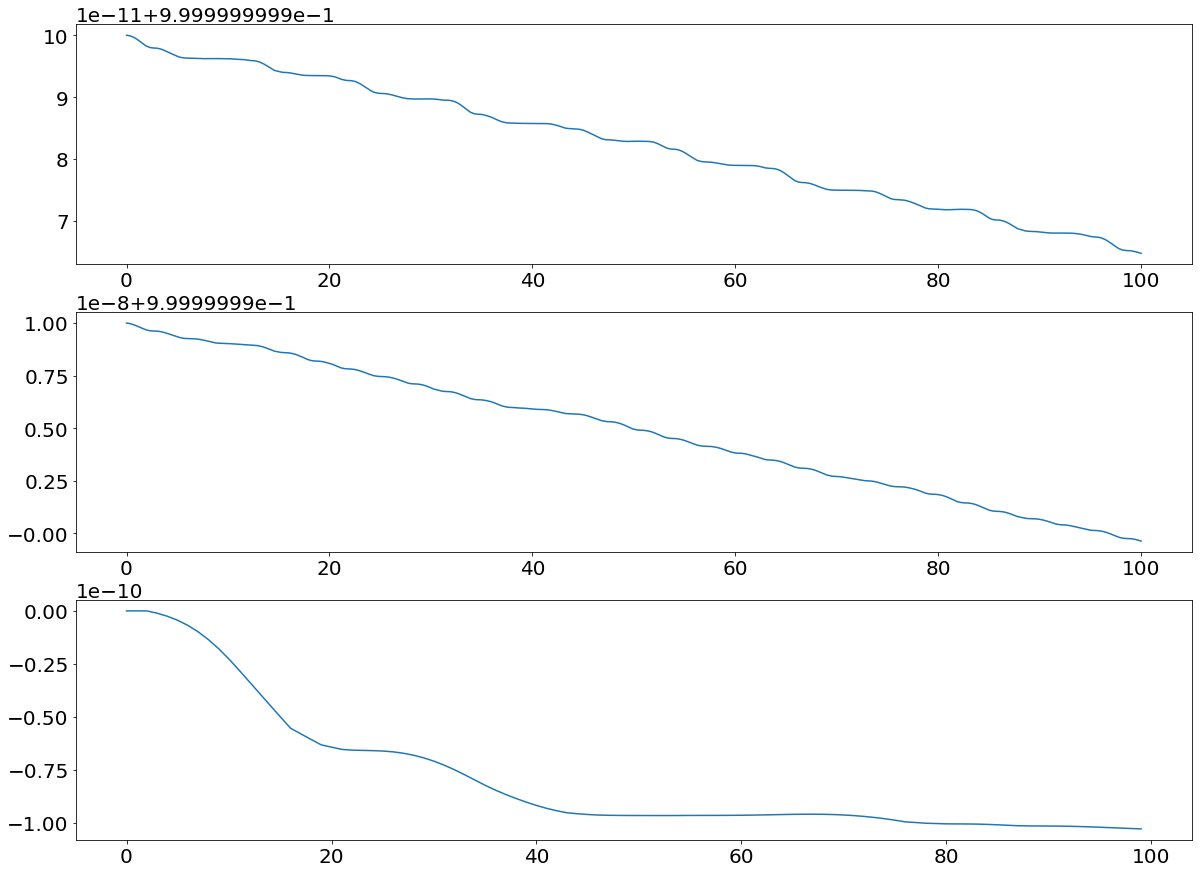

In [18]:
fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('white')
ax0, ax1, ax2 = fig.subplots(nrows=3, ncols=1, )
ax0.plot(Table_t, np.linalg.norm(Table_P, axis=1))
ax1.plot(Table_t, np.linalg.norm(Table_P2, axis=1))
ax2.plot(np.einsum('ij,ij->i',Table_P, Table_P2)[:100])
pass

In [ ]:
anim = spf_tb.make_table_video(Table_t, Table_X, Table_P, Table_P2, 
                               Table_theta, Table_phi, Table_psi, Table_eta,
                               zm_fct=0.003, stp=2, interval=40)
anim

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# anim.save('tmp.mp4', writer=writer)

last norm:  1.84117138933 , 4.51846520508 , 2.24685133378
do_calculate_ecoli_passive_Petsc: run 500 loops/times using 10.080217s


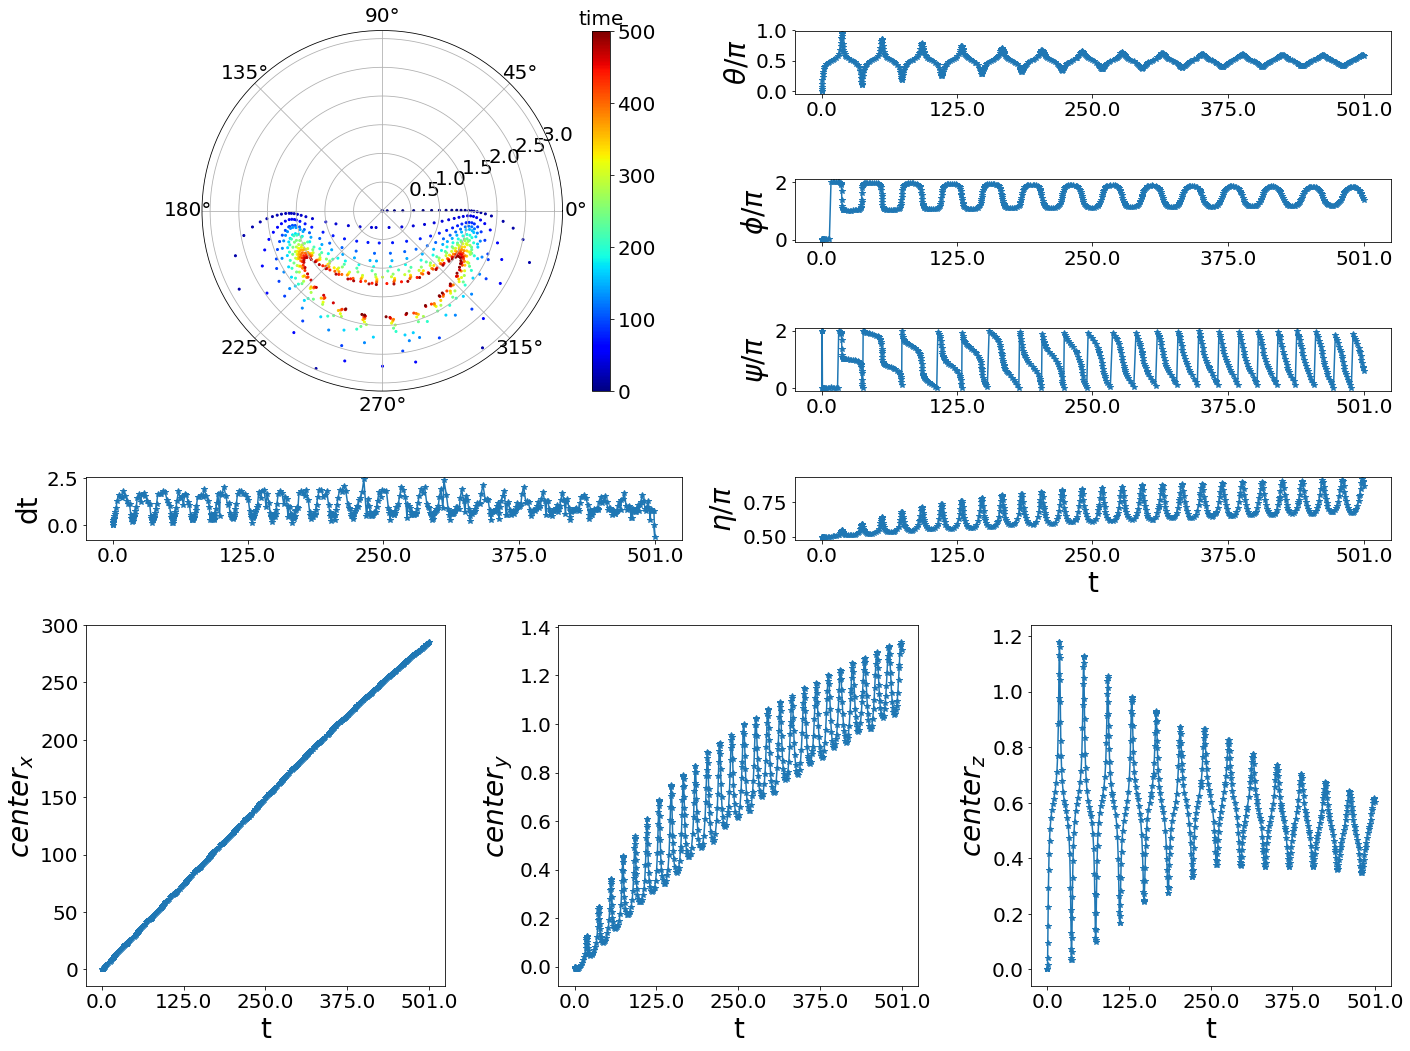

In [20]:
# passive ecoli
importlib.reload(spf_tb)
t0 = time()
t_theta, t_phi, t_psi = 0, 0, 0
max_t = 500
update_fun='5bs'
rtol=1e-6
atol=1e-9
eval_dt = 0.0001

tnorm = np.array((np.sin(t_theta) * np.cos(t_phi), np.sin(t_theta) * np.sin(t_phi), np.cos(t_theta)))
Table_t, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta \
   = spf_tb.do_calculate_ecoli_passive_Petsc(tnorm, t_psi, max_t, 
                                             update_fun=update_fun, rtol=rtol, atol=atol, eval_dt=eval_dt)
t1 = time()
print('last norm: ', Table_theta[-1], ',', Table_phi[-1], ',', Table_psi[-1])
print('%s: run %d loops/times using %fs' % ('do_calculate_ecoli_passive_Petsc', max_t, (t1 - t0)))
spf_tb.show_table_result(Table_t, Table_theta, Table_phi, Table_psi, Table_eta, Table_X)


In [ ]:
anim = spf_tb.make_table_video(Table_t, Table_X, Table_P, Table_P2, 
                               Table_theta, Table_phi, Table_psi, Table_eta,
                               zm_fct=30, stp=1, interval=20)
anim

In [57]:
importlib.reload(spf_tb)
finename = 'try1'

# spf_tb.show_table_result(Table_t, Table_theta, Table_phi, Table_psi, Table_eta, Table_X, save_every)
spf_tb.save_table_result(finename, Table_t, Table_theta, Table_phi, Table_psi, Table_eta, Table_X, save_every)


True